# "Build Your First Neural Network with PyTorch"

  * article <https://curiousily.com/posts/build-your-first-neural-network-with-pytorch/>
  * dataset <https://www.kaggle.com/jsphyg/weather-dataset-rattle-package>
  
requires `torch 1.4.0`

In [3]:
import os
from os.path import dirname
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch import nn, optim
import torch.nn.functional as F

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams["figure.figsize"] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
df = pd.read_csv(dirname(os.getcwd()) + "/dat/weatherAUS.csv")
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


In [5]:
df.shape

(142193, 24)

In [6]:
# data pre-processing
cols = [ "Rainfall", "Humidity3pm", "Pressure9am", "RainToday", "RainTomorrow" ]
df = df[cols]
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


In [7]:
df["RainToday"].replace({"No": 0, "Yes": 1}, inplace = True)
df["RainTomorrow"].replace({"No": 0, "Yes": 1}, inplace = True)
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0
1,0.0,25.0,1010.6,0.0,0
2,0.0,30.0,1007.6,0.0,0
3,0.0,16.0,1017.6,0.0,0
4,1.0,33.0,1010.8,0.0,0


In [8]:
# drop missing values
df = df.dropna(how="any")
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0
1,0.0,25.0,1010.6,0.0,0
2,0.0,30.0,1007.6,0.0,0
3,0.0,16.0,1017.6,0.0,0
4,1.0,33.0,1010.8,0.0,0


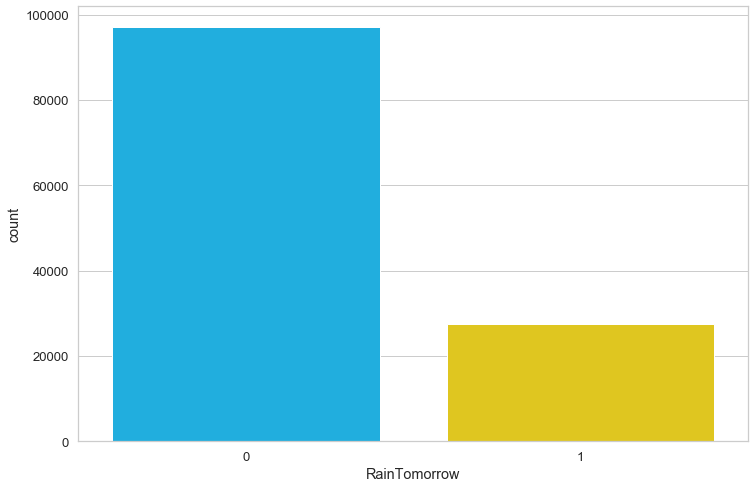

In [9]:
sns.countplot(df.RainTomorrow);

In [10]:
df.RainTomorrow.value_counts() / df.shape[0]

0    0.778762
1    0.221238
Name: RainTomorrow, dtype: float64

In [11]:
X = df[["Rainfall", "Humidity3pm", "RainToday", "Pressure9am"]]
y = df[["RainTomorrow"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [12]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
X_test = torch.from_numpy(X_test.to_numpy()).float()

y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


In [13]:
class Net (nn.Module):
    def __init__ (self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 5)
        self.fc2 = nn.Linear(5, 3)
        self.fc3 = nn.Linear(3, 1)
  

    def forward (self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [15]:
net = Net(X_train.shape[1])

In [16]:
# training
criterion = nn.BCELoss()

In [17]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [18]:
# weather forecast

def calculate_accuracy (y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    return (y_true == predicted).sum().float() / len(y_true)

In [20]:
def round_tensor (t, decimal_places=3):
    return round(t.item(), decimal_places)


MAX_EPOCH = 5000

for epoch in range(MAX_EPOCH):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 100 == 0:
        train_acc = calculate_accuracy(y_train, y_pred)
        
        y_test_pred = net(X_test)
        y_test_pred = torch.squeeze(y_test_pred)
        
        test_loss = criterion(y_test_pred, y_test)
        test_acc = calculate_accuracy(y_test, y_test_pred)
        
        print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

epoch 0
Train set - loss: 0.472, accuracy: 0.791
Test  set - loss: 0.473, accuracy: 0.792

epoch 100
Train set - loss: 0.474, accuracy: 0.792
Test  set - loss: 0.476, accuracy: 0.793

epoch 200
Train set - loss: 0.476, accuracy: 0.793
Test  set - loss: 0.477, accuracy: 0.793

epoch 300
Train set - loss: 0.476, accuracy: 0.793
Test  set - loss: 0.477, accuracy: 0.793

epoch 400
Train set - loss: 0.474, accuracy: 0.792
Test  set - loss: 0.476, accuracy: 0.793

epoch 500
Train set - loss: 0.472, accuracy: 0.792
Test  set - loss: 0.473, accuracy: 0.793

epoch 600
Train set - loss: 0.47, accuracy: 0.791
Test  set - loss: 0.471, accuracy: 0.792

epoch 700
Train set - loss: 0.468, accuracy: 0.79
Test  set - loss: 0.47, accuracy: 0.791

epoch 800
Train set - loss: 0.468, accuracy: 0.789
Test  set - loss: 0.47, accuracy: 0.79

epoch 900
Train set - loss: 0.469, accuracy: 0.789
Test  set - loss: 0.47, accuracy: 0.789

epoch 1000
Train set - loss: 0.47, accuracy: 0.789
Test  set - loss: 0.471, ac

In [21]:
# save the model
MODEL_PATH = "model.pth"
torch.save(net, MODEL_PATH)

In [22]:
# restore model
net = torch.load(MODEL_PATH)

In [25]:
# evaluation
classes = ["No rain", "Raining"]

y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.80      0.99      0.88     19413
     Raining       0.71      0.11      0.19      5525

   micro avg       0.79      0.79      0.79     24938
   macro avg       0.75      0.55      0.53     24938
weighted avg       0.78      0.79      0.73     24938



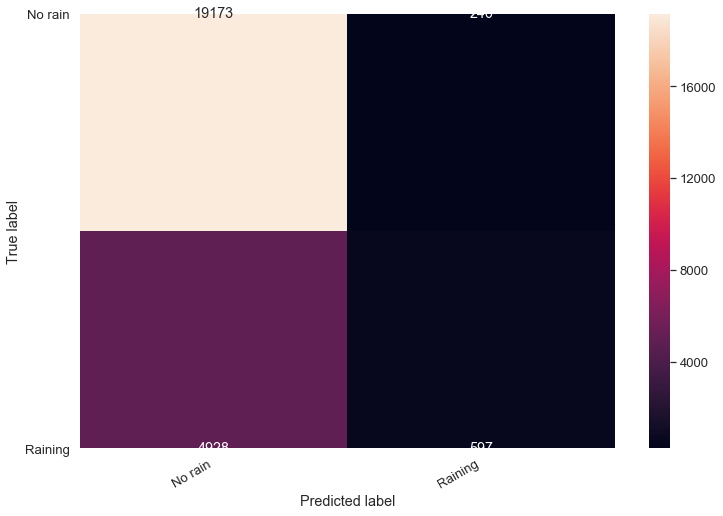

In [26]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

plt.ylabel('True label')
plt.xlabel('Predicted label');

In [27]:
def will_it_rain (rainfall, humidity, rain_today, pressure):
    t = torch.as_tensor([rainfall, humidity, rain_today, pressure]).float().cpu()
    output = net(t)
    print("net(t)", output.item())
    return output.ge(0.5).item()

In [28]:
will_it_rain(rainfall=10, humidity=10, rain_today=True, pressure=2)

net(t) 0.7304017543792725


True

In [29]:
will_it_rain(rainfall=0, humidity=1, rain_today=False, pressure=100)

net(t) 0.506089448928833


True